<a href="https://colab.research.google.com/github/Benyaminhosseiny/WetNet/blob/main/WetNet_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


  <td>
    <a target="_blank" href="https://github.com/Benyaminhosseiny/WetNet">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    Follow the repository on GitHub for possible updates</a>
  </td>

WetNet: A Spatial–Temporal Ensemble Deep Learning Model for Wetland Classification Using Sentinel-1 and Sentinel-2

link to the paper:

https://ieeexplore.ieee.org/document/9576524/



model.jpg

# Import Libraries

In [ ]:
#Add NN Libraries
import tensorflow as tf
import keras
from keras import regularizers
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import BatchNormalization,Activation, ReLU, Add,Conv2D,MaxPooling2D, Conv3D,Input, Dense, Flatten, \
Dropout,Concatenate,LSTM, GRU, SimpleRNN, Bidirectional, Reshape, MaxPool2D,AveragePooling3D, MaxPooling3D,TimeDistributed, add
from tensorflow.compat.v1.keras.layers import CuDNNLSTM,CuDNNGRU
from tensorflow.keras.backend import squeeze
from keras.constraints import maxnorm
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adamax, Nadam
from keras.regularizers import l2
from keras.utils import np_utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')

print('TF version: ', tf.__version__)
print('KERAS version: ', keras.__version__)
print(K.image_data_format())

TF version:  2.6.0
KERAS version:  2.6.0
channels_last


In [ ]:
# GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at:{}'.format(device_name))

Found GPU at:/device:GPU:0


# Functions

## Feed-Forwards

###### 3D Res

In [ ]:
def CONV3D_section(INPUT, layers_num, kernels_num = 64, kernels_shape = (3,3,3), strides=(1,1,1), padding='valid', reg=0, Name = ''):
  conv_layer = INPUT
  for ii in range(layers_num):
    conv_layer = Conv3D(kernels_num, kernels_shape,
                        kernel_regularizer=regularizers.l2(reg),
                        activity_regularizer=regularizers.l2(reg),
                        activation='relu',
                        strides=strides,
                        padding=padding,
                        kernel_initializer='he_uniform',
                        name = Name+'_Conv3D'+str(ii),data_format="channels_last")(conv_layer)
    conv_layer = BatchNormalization(name = Name+'_BN'+str(ii))(conv_layer)
    conv_layer = Dropout(0.2, name = Name+'_DO'+str(ii))(conv_layer)
  #
  return conv_layer
#
def Conv3d_BN(x, nb_filter, kernel_size, strides=(1,1,1), padding='same', name=None):
    x = Conv3D(nb_filter, kernel_size, padding=padding, data_format='channels_last', strides=strides,
               kernel_initializer='he_uniform', #'he_normal'
               activation='relu')(x)
    x = BatchNormalization()(x)
    return x
#
def identity_Block(inpt, nb_filter, kernel_size, strides=(1,1,1), padding='same', with_conv_shortcut=False):
    x = Conv3d_BN(inpt, nb_filter=nb_filter, kernel_size=kernel_size, strides=strides, padding=padding)
    x = Conv3d_BN(x, nb_filter=nb_filter, kernel_size=kernel_size, padding=padding)
    if with_conv_shortcut:
        shortcut = Conv3d_BN(inpt, nb_filter=nb_filter, strides=strides, padding=padding,
                             kernel_size=kernel_size)
        x = Dropout(0.2)(x)
        x = add([x, shortcut])
        return x
    else:
        x = add([x, inpt])
        return x

######2D CNNs

In [ ]:
# https://machinelearningmastery.com/how-to-implement-major-architecture-innovations-for-convolutional-neural-networks/

# function for creating a projected inception module
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
	# 1x1 conv
	conv1 = Conv2D(f1, (1,1), padding='same', activation='relu', kernel_initializer='he_uniform', #'he_normal'
                )(layer_in)
	# 3x3 conv
	conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu', kernel_initializer='he_uniform', #'he_normal'
                )(layer_in)
	conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', #'he_normal'
                )(conv3)
	# 5x5 conv
	conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu', kernel_initializer='he_uniform', #'he_normal'
                )(layer_in)
	conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu', kernel_initializer='he_uniform', #'he_normal'
                )(conv5)
	# 3x3 max pooling
	pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
	pool = Conv2D(f4_out, (1,1), padding='same', activation='relu', kernel_initializer='he_uniform', #'he_normal'
               )(pool)
	# concatenate filters, assumes filters/channels last
	layer_out = Concatenate(axis=-1)([conv1, conv3, conv5, pool])
	return layer_out

##### Recurrents

In [ ]:
def recurrent_section(INPUT, model = 'SimpleRNN', layers_num=1, neurons = 100, activation='tanh',recurrent_activation='sigmoid', reg=0,return_sequences=True, Name = ''):

  RECURRENT_layer = INPUT
  for ii in range(layers_num):
    if model == 'SimpleRNN':
      RECURRENT_layer = SimpleRNN( units=neurons, use_bias=False, activation=activation,return_sequences=return_sequences, #return_state=True,
                            kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', #glorot_uniform
                            kernel_regularizer=regularizers.l2(reg), recurrent_regularizer=regularizers.l2(reg),activity_regularizer=regularizers.l2(reg),
                            dropout=0.0, recurrent_dropout=0.0, name = Name+'_Recurrent'+str(ii) )(RECURRENT_layer)
    if model == 'LSTM':
      RECURRENT_layer = LSTM( units=neurons, use_bias=False, activation=activation, recurrent_activation=recurrent_activation,return_sequences=return_sequences, #return_state=True,
                            kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros',
                            kernel_regularizer=regularizers.l2(reg), recurrent_regularizer=regularizers.l2(reg), activity_regularizer=regularizers.l2(reg),
                            dropout=0.0, recurrent_dropout=0.0, name = Name+'_Recurrent'+str(ii) )(RECURRENT_layer)
    if model == 'GRU':
      RECURRENT_layer = GRU( units=neurons, use_bias=False, activation=activation, recurrent_activation=recurrent_activation,return_sequences=return_sequences, #return_state=True,
                            kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros',
                            kernel_regularizer=regularizers.l2(reg), recurrent_regularizer=regularizers.l2(reg), activity_regularizer=regularizers.l2(reg),
                            dropout=0.0, recurrent_dropout=0.0, name = Name+'_Recurrent'+str(ii) )(RECURRENT_layer)
    RECURRENT_layer = BatchNormalization(name = Name+'_BN_Recurrent'+str(ii))(RECURRENT_layer)
  return RECURRENT_layer
#
def CUDrecurrent_section(INPUT, model = 'LSTM',layers_num=1, neurons = 100,reg=0.0,return_sequences=True, Name = ''):
  RECURRENT_layer = INPUT
  for ii in range(layers_num):
    if model == 'LSTM':
      RECURRENT_layer = CuDNNLSTM( units=neurons, return_sequences=return_sequences, #activity_regularizer=regularizers.l1_l2(reg/1000),
                                   kernel_regularizer=regularizers.l1_l2(reg), recurrent_regularizer=regularizers.l1_l2(reg))(RECURRENT_layer)
    if model == 'GRU':
      RECURRENT_layer = CuDNNGRU( units=neurons, return_sequences=return_sequences, #activity_regularizer=regularizers.l1_l2(reg/1000),
                                   kernel_regularizer=regularizers.l1_l2(reg), recurrent_regularizer=regularizers.l1_l2(reg))(RECURRENT_layer)
    if model == 'BiLSTM':
      RECURRENT_layer = Bidirectional( CuDNNLSTM( units=neurons, return_sequences=return_sequences, #activity_regularizer=regularizers.l1_l2(reg/1000),
                                   kernel_regularizer=regularizers.l1_l2(reg), recurrent_regularizer=regularizers.l1_l2(reg)) )(RECURRENT_layer)
    if model == 'BiGRU':
      RECURRENT_layer = Bidirectional( CuDNNGRU( units=neurons, return_sequences=return_sequences, #activity_regularizer=regularizers.l1_l2(reg/1000),
                                   kernel_regularizer=regularizers.l1_l2(reg), recurrent_regularizer=regularizers.l1_l2(reg)) )(RECURRENT_layer)

    # RECURRENT_layer = BatchNormalization(name = Name+'_BN_Recurrent'+str(ii))(RECURRENT_layer)
  return RECURRENT_layer
#
def Bidirectional_recurrent_section(INPUT, layers_num, neurons = 100, reg=0,return_sequences=True, Name = ''):
  RECURRENT_layer = INPUT
  for ii in range(layers_num):
    RECURRENT_layer = Bidirectional( units=neurons, return_sequences=return_sequences, activity_regularizer=regularizers.l1_l2(reg/1000),
                                   kernel_regularizer=regularizers.l1_l2(reg), recurrent_regularizer=regularizers.l1_l2(reg) )(RECURRENT_layer)
    RECURRENT_layer = BatchNormalization(name = Name+'_BN_Recurrent'+str(ii))(RECURRENT_layer)
  #
  return RECURRENT_layer

#WetNet

In [ ]:
p = 15
ts = 10
classes= 8

S1_cube_shape = [p,p,2*ts,1]
S2_cube_shape = [p,p,4*ts,1]
MV_shape = [ts,6]

In [ ]:
def model_function():
  S1_input = Input(S1_cube_shape[:-1], name='S1_input')
  S2_input = Input(S2_cube_shape, name='S2_input')
  MV_input = Input((MV_shape), name='MV_input')
  #
  cnn_reg = 0.000
  rnn_reg = 0.0000

  # S1
  S1_Conv = inception_module(S1_input, f1=64, f2_in=96, f2_out=128, f3_in=16, f3_out=32, f4_out=32)
  S1_Conv = inception_module(S1_Conv, f1=64, f2_in=96, f2_out=128, f3_in=16, f3_out=32, f4_out=32)

  S1_flat = Flatten(name = 'S1_Flatten')(S1_Conv)

  # S2
  S2_Conv = CONV3D_section(S2_input, layers_num = 1, kernels_num = 64, kernels_shape = (3,3,3), strides=(2,2,2), reg=cnn_reg, padding='valid', Name='S2_1')
  S2_Conv = identity_Block(S2_Conv, nb_filter = 64, kernel_size = (3,3,3), strides=1, padding='same', with_conv_shortcut=False)
  S2_Conv = identity_Block(S2_Conv, nb_filter = 64, kernel_size = (3,3,3), strides=(2,2,2), padding='same', with_conv_shortcut=True)
  S2_flat = Flatten(name = 'S2_Flatten')(S2_Conv)
  # S2_flat = BatchNormalization()(S2_flat)

  # MV TS # Select between LSTM | SimpleRNN | GRU
  # For TPU: use recurrent_section instead of CUDrecurrent_section
  MV_Recurrent = CUDrecurrent_section(MV_input, model = 'LSTM', layers_num=1, neurons = 1024,reg=rnn_reg, Name = 'MV1') # does not support RNN
  # MV_Recurrent = TimeDistributed(Dense(1024, activation='tanh'))(MV_Recurrent)
  MV_Recurrent = CUDrecurrent_section(MV_Recurrent, model = 'LSTM', layers_num=1, neurons = 512,reg=rnn_reg, Name = 'MV2') # does not support RNN
  # MV_Recurrent = recurrent_section(MV_input, model = 'SimpleRNN', layers_num=2, neurons = 256, activation='tanh',recurrent_activation='sigmoid',return_sequences=True, Name = 'MV')
  MV_Recurrent = TimeDistributed(Dense(512, activation='tanh'))(MV_Recurrent)
  # MV_Recurrent = Dropout(0.5)(MV_Recurrent)

  MV_flat = Flatten(name = 'MV_Flatten')(MV_Recurrent)
  # MV_flat = BatchNormalization()(MV_flat)

  #
  concat_layer= Concatenate(name='Concat')([S1_flat, S2_flat, MV_flat])
  dense_reg=0.005

  # MLP SECTION
  Output_rnn = Dense(classes,activation='linear',kernel_regularizer=l2(dense_reg), activity_regularizer=l2(dense_reg),name = 'Output_rnn')(MV_flat)
  Output_cnn_s1 = Dense(classes,activation='linear',kernel_regularizer=l2(dense_reg), activity_regularizer=l2(dense_reg),name = 'Output_cnn_s1')(S1_flat)
  Output_cnn_s2 = Dense(classes,activation='linear',kernel_regularizer=l2(dense_reg), activity_regularizer=l2(dense_reg),name = 'Output_cnn_s2')(S2_flat)
  Output_cnn_rnn = Dense(classes,activation='linear',kernel_regularizer=l2(dense_reg), activity_regularizer=l2(dense_reg),name = 'Output_cnn_rnn')(concat_layer)

  Output_concat= Concatenate(name='Concat_Classifiers')([Output_rnn, Output_cnn_s1, Output_cnn_s2,Output_cnn_rnn])
  Output_final = Dense(classes,activation='linear',#'softmax',
                      kernel_regularizer=l2(dense_reg), activity_regularizer=l2(dense_reg),
                      name = 'Output_Final')(Output_concat)
  #
  # #
  # # #
  model = Model(inputs=[S1_input, S2_input, MV_input], outputs=[Output_final, Output_rnn, Output_cnn_s1, Output_cnn_s2, Output_cnn_rnn])

  return model
model = model_function()

In [ ]:
model.summary(line_length=130)

Model: "model"
__________________________________________________________________________________________________________________________________
Layer (type)                              Output Shape                 Param #         Connected to                               
S2_input (InputLayer)                     [(None, 15, 15, 40, 1)]      0                                                          
__________________________________________________________________________________________________________________________________
S2_1_Conv3D0 (Conv3D)                     (None, 7, 7, 19, 64)         1792            S2_input[0][0]                             
__________________________________________________________________________________________________________________________________
S2_1_BN0 (BatchNormalization)             (None, 7, 7, 19, 64)         256             S2_1_Conv3D0[0][0]                         
____________________________________________________________________

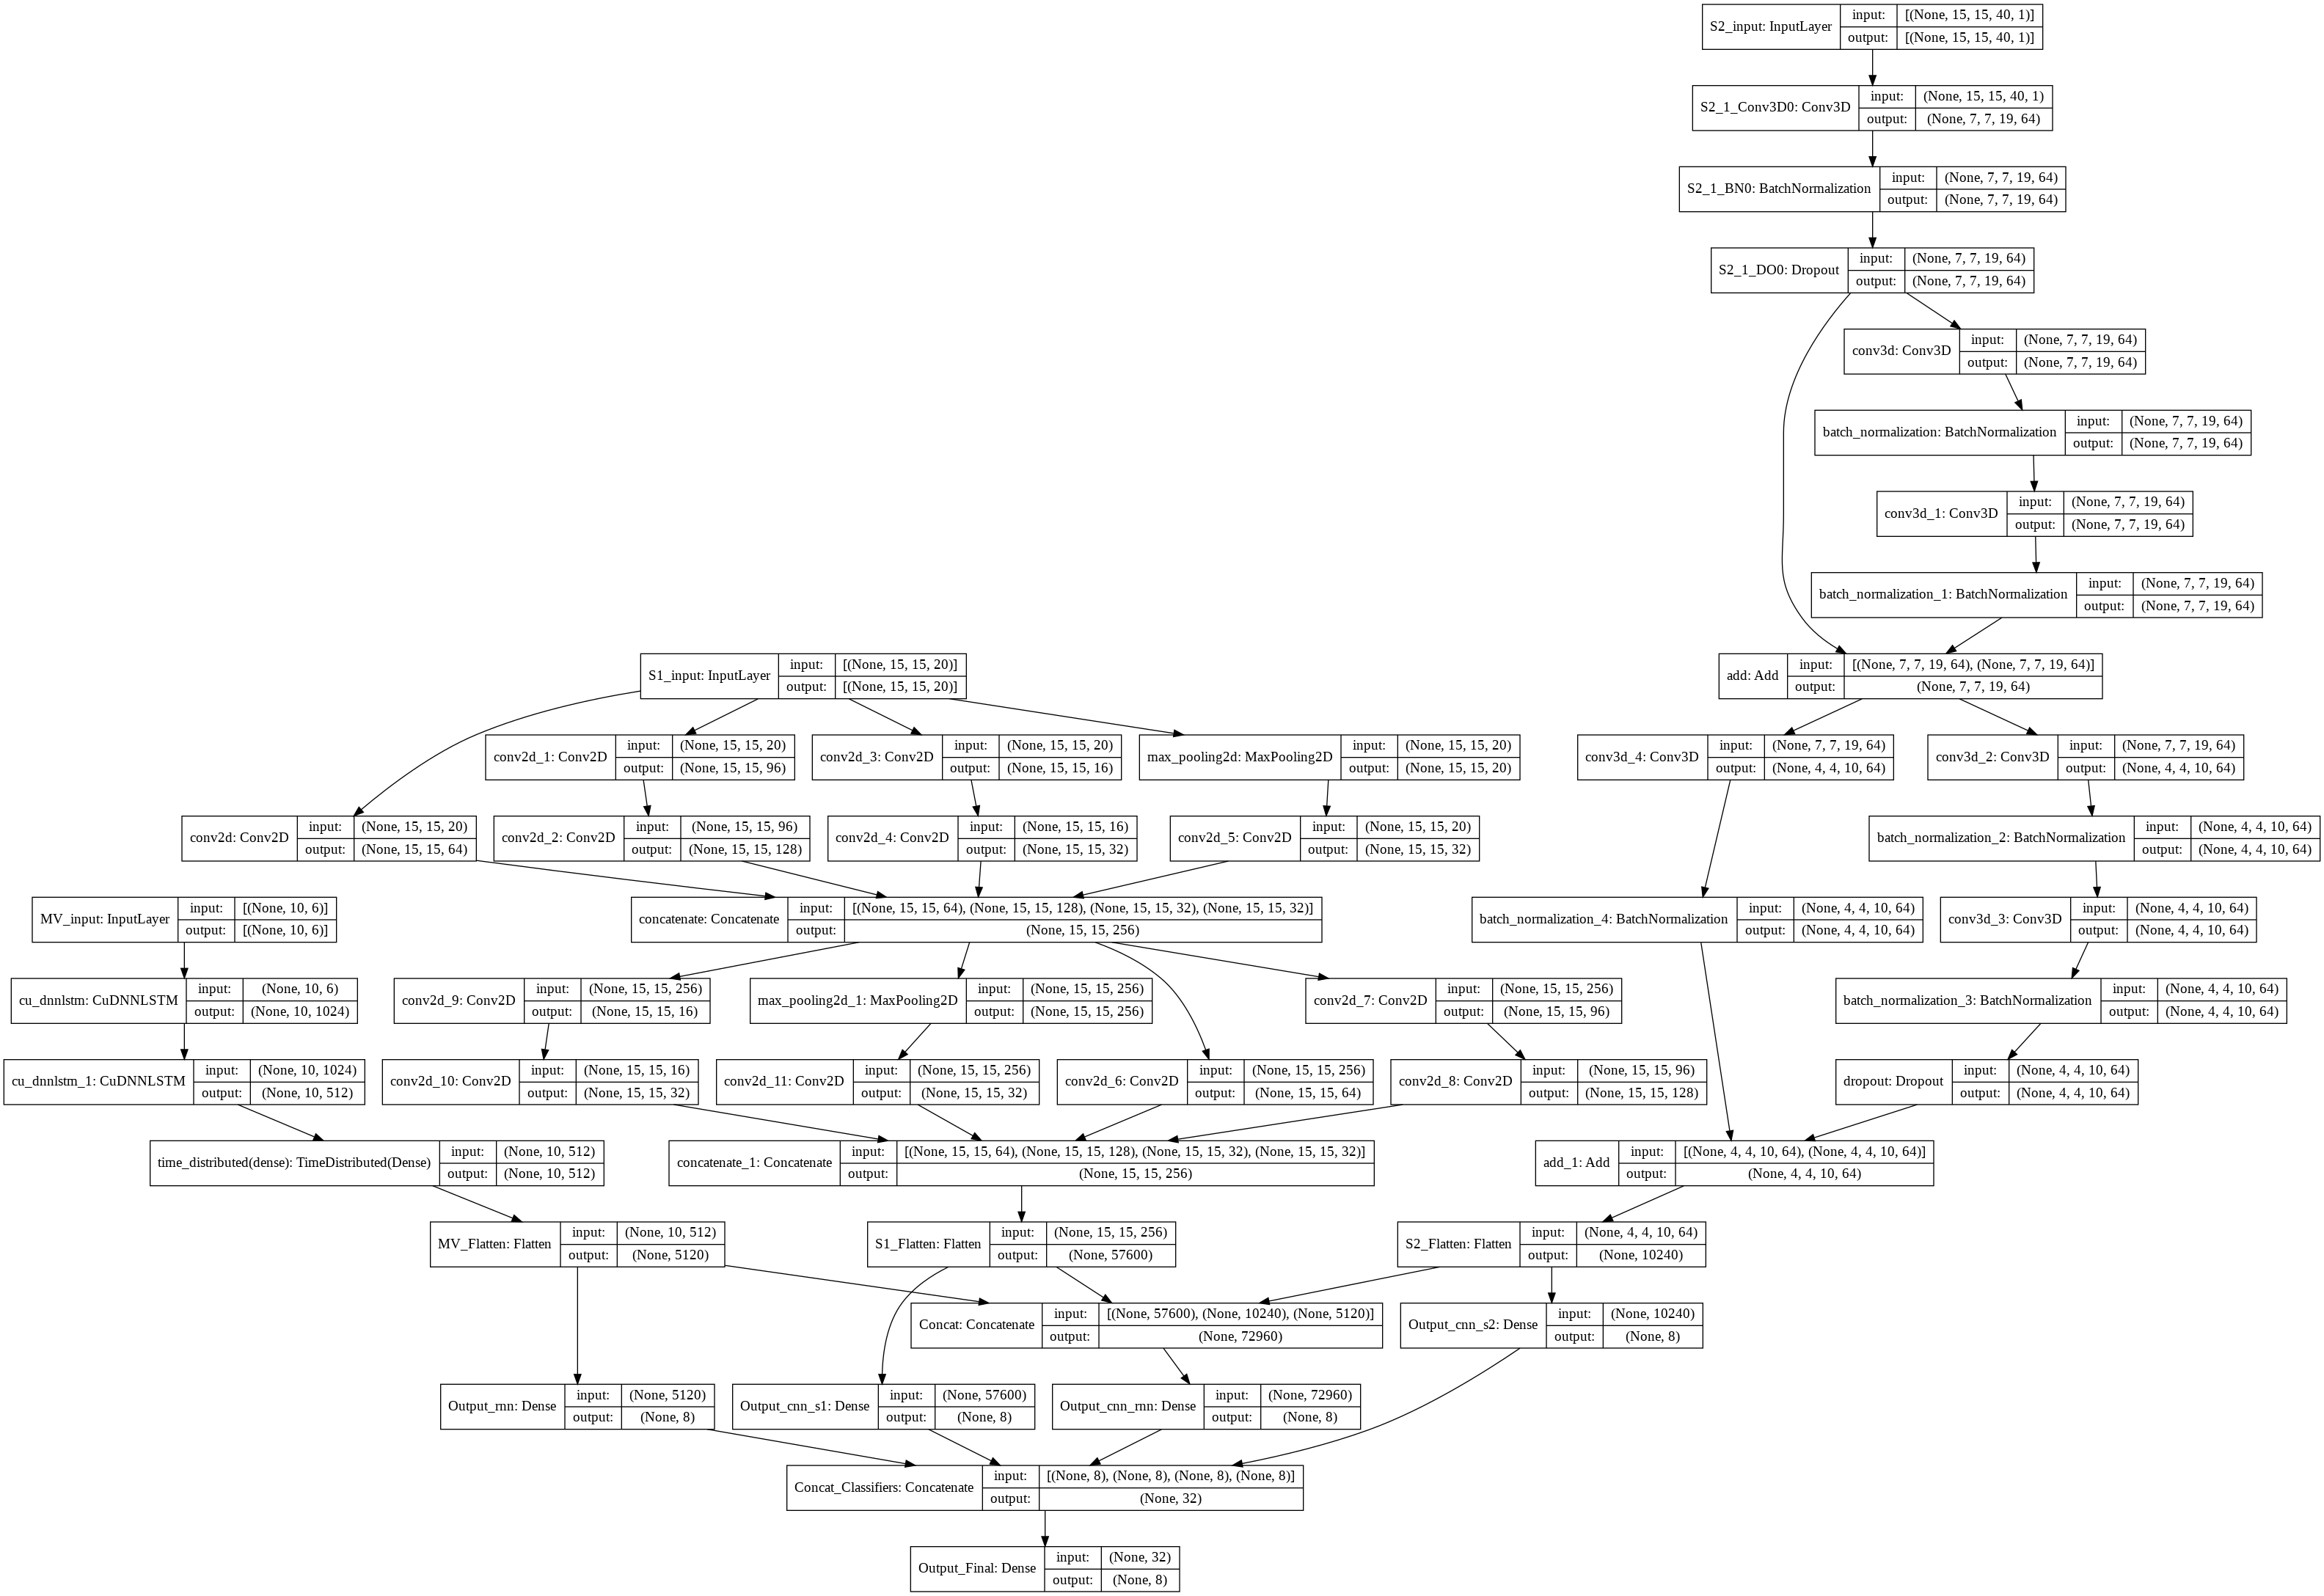

In [ ]:
plot_model(model,show_shapes=True,show_layer_names=True)